## Table of contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
<li><a href="#issues">Observed issues</a></li>
<li><a href="#clean">Cleaning Data</a></li>
<li><a href="#storing">Storing Wrangled Data</a></li>
<li><a href="#acting">Acting on Wrangled Data</a></li>
<li><a href="#references">References</a></li>
</ul>


<a id='intro'></a>
## Introduction

Real-world data rarely comes clean. Using Python and its libraries, I will gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it. This is called data wrangling. I will document my wrangling efforts in a Jupyter Notebook, plus showcase them through analyses and visualizations using Python (and its libraries) and/or SQL.

The dataset that I will be wrangling, analyzing and visualizing is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

I will access the twitter api to gather some additional data to complete the provided dataframe by Udacity.
The data I chose are:

- tweet id: To join with provided dataframe
- type of tweet media: To check if exists other type of media in tweets of @dog_rates, like video for example
- replies and retweeted tweets fields: To compare with the provided dataframe and grant to analyze only original tweets (no retweets)
- Retweets counts of a original tweet (required)
- Favorite counts of a original tweet (required)


<a id='gather'></a>
## Gathering Data

In [1]:
# Import libraries
# Basic libs
import time
import os
import requests

# Data analysis libs
import pandas as pd
import numpy as np
import tweepy
import json
from sqlalchemy import create_engine

# Visualization libs
import matplotlib.pyplot as plt
import seaborn as sn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Magic keywords and plot grid style
%matplotlib inline
sn.set_style('darkgrid')

In [2]:
# Configure twitter api keys

consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)

In [3]:
# Import the WeRateDogs twitter archive and store into dataframe df_wrd
df_wrd = pd.read_csv('twitter-archive-enhanced.csv')

In [4]:
# Import Image predictions archive and store into dataframe df_ipr
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
file_name = url.split('/')[-1]

with open (url.split('/')[-1], 'wb') as file:
    file.write(response.content)

df_ipr = pd.read_csv(file_name, sep='\t')

**Query twitter api**

Verify if text file exists:<br />
If exists, continue.<br />
If not, iterate in tweet id's from twitter-archive-enhanced file to gather the necessary data.

In [5]:
start = time.time()
if os.path.isfile('tweet_json.txt'):
    pass
else:
    for i in df_wrd['tweet_id']:
        try:
            # Pass id's (i) from twitter-archive-enhanced file to twitter api
            tweet = api.get_status(i, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
            with open('tweet_json.txt', 'a') as file:
                file.write(json.dumps(tweet._json) + '\n')
        except tweepy.TweepError as e:
            # Failed queries  and respective ids will be stored in tweet_json_failed file
            with open ('tweet_json_failed.txt', 'a') as file_e:
                # Use replace because: Expecting property name enclosed in double quotes
                file_e.write(str({ "id": i,
                               "code": e.args[0][0]['code'],
                               "message": e.args[0][0]['message'] }).replace("'",'"') + '\n')
end = time.time()

Rate limit reached. Sleeping for: 235
Rate limit reached. Sleeping for: 197


In [6]:
print('Total time: {} minutes approximately'.format(round((end - start) / 60)))

Total time: 37 minutes approximately


In [7]:
# Read line by line from data gathered on api anda store in data variable
with open('tweet_json.txt') as file:
    data = file.readlines()

#Iterate in each line from data_f and use json loads to decode data correctly
for i,j in enumerate(data):
    data[i] = json.loads(j)

# Read line by line from data gathered on api anda store in data_f variable
with open('tweet_json_failed.txt') as file_e:
    data_f = file_e.readlines()

# Iterate in each line from data_f and use json loads to decode data correctly
for i,j in enumerate(data_f):
    data_f[i] = json.loads(j)

In [8]:
# Create a dataframe for each api data gathered
df_api_failed = pd.DataFrame(data_f)
df_api = pd.DataFrame(data)

In [9]:
# Select only necessary data in api dataframe, with is: id, entities(media(type)), retweeted_status, in_reply_to_status_id, retweet_count, favorite_count
columns_api = ['id','entities','retweeted_status','in_reply_to_status_id','retweet_count','favorite_count']
df_api = df_api[columns_api].copy()

In [10]:
# Other way to gather data from twitter api
# Instead of save a file with json data, query and store in directly in a list of dictionaries
if os.path.isfile('tweet_json.txt'):
    pass
else:
    start = time.time()
    list_of_tweets = []
    list_of_failed_tweets = []

    for i in df_wrd['tweet_id']:
        try:
            tweet = api.get_status(i, tweet_mode='extended', wait_on_rate_limit=True, wait_on_rate_limit_notify=True)
        
            list_of_tweets.append({'id': tweet.id,
                                   'retweet_count': tweet.retweet_count,
                                   'favorite_count': tweet.favorite_count})
        except tweepy.TweepError as e:
            list_of_failed_tweets.append({'id': i,
                                          'error_code': e.args[0][0]['code'],
                                          'error_message': e.args[0][0]['message']})

end = time.time()

<a id='assess'></a>
## Assessing Data

#### Visual assess of twitter-archive-enhanced dataframe:

In [11]:
df_wrd.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Programmatic assess of twitter-archive-enhanced dataframe:

In [12]:
df_wrd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
# Have a deep look in source and text fields to detect quality problems
for i in df_wrd.sample(5).values:
    print(i[0],'\n', i[4],'\n', i[5],'\n\n')

672877615439593473 
 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a> 
 This is Oscar. He's getting bombarded with the snacks. Not sure he's happy about it. 8/10 for Oscar https://t.co/dJHI7uC2y3 


852226086759018497 
 <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a> 
 Meet General. He wasn't content with the quality of his room. Requested to pupgrade, but was ignored. 14/10 look who just lost a customer https://t.co/NP5JW8LnmW 


782969140009107456 
 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a> 
 This is Cali. She arrived preassembled. Convenient af. 12/10 appears to be rather h*ckin pettable https://t.co/vOBV1ZqVcX 


702671118226825216 
 <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a> 
 Meet Rambo &amp; Kiwi. Rambo's the pup with the sharp toes &amp; rad mohawk. One stays woke while one sleeps. 10/10 for both https://t.co/MpH1Fe9LhZ 


778650543019483137 
 <a

In [14]:
# Stranger names finded
df_wrd.groupby('name')['name'].count().tail(25)

name
a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [15]:
# Check dog stages according with Dogtionary
# Everything looks like ok in dog stages
for i in df_wrd.sample(5).values:
    print(i[0],'\n', i[5],'\n', i[13],'\n', i[14],'\n', i[15],'\n', i[16],'\n\n')

805207613751304193 
 This is Shooter. He's doing quite the snowy zoom. 12/10 https://t.co/lHy4Xbyhd9 
 None 
 None 
 None 
 None 


668113020489474048 
 This is Alfie. He's that one hypocritical gym teacher who made you run laps. Great posture. Cool bench. 6/10 https://t.co/GCJzm3YsfX 
 None 
 None 
 None 
 None 


677644091929329666 
 This is a dog swinging. I really enjoyed it so I hope you all do as well. 11/10 https://t.co/Ozo9KHTRND 
 None 
 None 
 None 
 None 


887517139158093824 
 I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba 
 None 
 None 
 None 
 None 


725458796924002305 
 Pup had to be removed cuz it wouldn't have been fair to the opposing team. 13/10 absolute legend ⚽️
https://t.co/BHICimO58W 
 None 
 None 
 None 
 None 




In [16]:
#Check for duplicates
df_wrd.duplicated().sum()

0

#### Visual assess of image-predictions dataframe:

In [17]:
df_ipr.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [18]:
df_ipr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [19]:
df_ipr.duplicated().sum()

0

#### Visual assess of data from Twitter api:

In [20]:
df_api.head()

,id,entities,retweeted_status,in_reply_to_status_id,retweet_count,favorite_count
0,892420643555336193,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,7636,35945
1,892177421306343426,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,5647,31024
2,891815181378084864,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,3742,23343
3,891689557279858688,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,7809,39236
4,891327558926688256,"{'hashtags': [{'text': 'BarkWeek', 'indices': ...",NaN,NaN,8401,37479


In [21]:
df_api.sample(5)

,id,entities,retweeted_status,in_reply_to_status_id,retweet_count,favorite_count
1198,714258258790387713,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,712,2988
623,793226087023144960,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,2915,9968
1721,679132435750195208,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,1132,2926
22,887473957103951883,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,16275,64041
88,875021211251597312,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,4291,23862


#### Programmatic assess of Twitter api dataframe

In [22]:
df_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2331 non-null   int64  
 1   entities               2331 non-null   object 
 2   retweeted_status       163 non-null    object 
 3   in_reply_to_status_id  77 non-null     float64
 4   retweet_count          2331 non-null   int64  
 5   favorite_count         2331 non-null   int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 109.4+ KB


In [23]:
df_api[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,2331.000000,2331.000000
mean,2680.358215,7509.601888
std,4532.502272,11657.586348
min,1.000000,0.000000
25%,543.000000,1308.000000
50%,1256.000000,3265.000000
75%,3115.000000,9193.000000
max,77068.000000,155081.000000


In [24]:
df_api.query("retweet_count == 1")

,id,entities,retweeted_status,in_reply_to_status_id,retweet_count,favorite_count
279,838085839343206401,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,8.380855e+17,1,138


In [25]:
# Looks like the favorite count equal to 0 come from retweets.
df_api.query("favorite_count == 0")

,id,entities,retweeted_status,in_reply_to_status_id,retweet_count,favorite_count
31,886054160059072513,"{'hashtags': [{'text': 'BATP', 'indices': [21,...",{'created_at': 'Sat Jul 15 02:44:07 +0000 2017...,NaN,100,0
35,885311592912609280,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Sun Feb 12 01:04:29 +0000 2017...,NaN,16738,0
67,879130579576475649,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Fri Jun 23 01:10:23 +0000 2017...,NaN,6167,0
72,878404777348136964,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Fri Jun 23 16:00:04 +0000 2017...,NaN,1166,0
73,878316110768087041,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Tue Nov 24 03:51:38 +0000 2015...,NaN,6030,0
...,...,...,...,...,...,...
999,746521445350707200,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Sat Nov 21 00:46:50 +0000 2015...,NaN,976,0
1019,743835915802583040,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Thu Nov 19 00:32:12 +0000 2015...,NaN,2050,0
1218,711998809858043904,"{'hashtags': [{'text': 'LoveTwitter', 'indices...",{'created_at': 'Mon Mar 21 19:29:52 +0000 2016...,NaN,125,0
2234,667550904950915073,"{'hashtags': [], 'symbols': [], 'user_mentions...",{'created_at': 'Fri Nov 20 03:43:06 +0000 2015...,NaN,32,0


#### Visual assess of data that failed from Twitter api:

In [26]:
df_api_failed.head()

,id,code,message
0,888202515573088257,144,No status found with that ID.
1,873697596434513921,144,No status found with that ID.
2,872668790621863937,144,No status found with that ID.
3,872261713294495745,144,No status found with that ID.
4,869988702071779329,144,No status found with that ID.


#### Programmatic assess of Twitter api failed dataframe

In [27]:
df_api_failed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       25 non-null     int64 
 1   code     25 non-null     int64 
 2   message  25 non-null     object
dtypes: int64(2), object(1)
memory usage: 728.0+ bytes


<a id='issues'></a>
## Observed issues

### Quality issues

`twitter-archive-enhanced` table:

- Missing data in in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp, expanded_urls
- HTML code in source variable
- Accuracy error in name column, strange names like: 'the', 'this', 'unacceptable', 'very', 'just', 'a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', finded, all starting with lower case
- The ratings probably aren't all correct
- Timestamp variable like a object data type
- Remove retweets and in_reply variables
- Repeated values in expanded_urls variable

`image-predictions` table:

- I did not find quality errors


`twitter-api` table:

- retweet_count equal to 1. Its possible?
- favorite_count equal to 0. Its possible?
- The scope of this project, not consider retweets and replies, so NaN must be consider in both variables


`twitter-api-failed` table:

- No quality errors

### Tidiness issues

`twitter-archive-enhanced` table:

- text column does not follow the rule: each variable form a column because have text and link of post in the same place.


`twitter-api` table:

- Multiple variables in the same column "entities"
- Join twitter-api with twitter-archive-enhanced to comply with tidy rule: Each type of observational unit forms a table


`image-predictions` table:

- Join image-predictions with `twitter-archive-enhanced` to comply with tidy rule: Each type of observational unit forms a table 


`twitter-api-failed` table:

- Join with `twitter-archive-enhanced` table to exclude tweets that not finded

<a id='clean'></a>
## Cleaning Data

### Define, clean and test

1. (missing data) Drop rows in `twitter-archive-enhanced` that are stored in `twitter-api-failed` table

In [28]:
df_wrd_clean = df_wrd.copy()

In [29]:
initial_wrd_wntries = df_wrd_clean.shape[0]
print("Total records in df_wrd_clean before drop: {}".format(initial_wrd_wntries))

Total records in df_wrd_clean before drop: 2356


In [30]:
for i in df_api_failed.values:
    df_wrd_clean.drop(df_wrd_clean[df_wrd_clean['tweet_id'] == i[0]].index, inplace=True)

In [31]:
api_failed_val = initial_wrd_wntries - df_wrd_clean.shape[0]
print("Total records in df_wrd_clean before drop: {}".format(df_wrd_clean.shape[0]))

Total records in df_wrd_clean before drop: 2331


In [32]:
# Reset index to correct gap failures generate by drop process
df_wrd_clean.reset_index(drop=True, inplace=True)

**All failed tweets removed**

In [33]:
df_api_failed.shape[0] == (2356 - 2331)

True

<br/>

2. (missing data) Remove retweets and in_reply variables: `twitter-archive-enhanced` table

    In this case, NaN values will be considered because filled values means retweet posts

In [34]:
re_removed_wrd = df_wrd_clean[df_wrd_clean['retweeted_status_id'].notna()]['retweeted_status_id'].count()
reply_removed_wrd = df_wrd_clean[df_wrd_clean['in_reply_to_status_id'].notna()]['in_reply_to_status_id'].count()

print("Total rows in twitter-archive-enhanced before drop: {}".format(df_wrd_clean.shape[0]))
print("Total retweets to be removed: {}".format(re_removed_wrd))
print("Total replies to be removed: {}".format(reply_removed_wrd))

Total rows in twitter-archive-enhanced before drop: 2331
Total retweets to be removed: 163
Total replies to be removed: 78


In [35]:
df_wrd_clean.drop(df_wrd_clean[df_wrd_clean['retweeted_status_id'].notna()].index, inplace=True)
df_wrd_clean.drop(df_wrd_clean[df_wrd_clean['in_reply_to_status_id'].notna()].index, inplace=True)

In [36]:
print("Total rows in twitter-archive-enhanced after drop: {}".format(df_wrd_clean.shape[0]))

Total rows in twitter-archive-enhanced after drop: 2090


In [37]:
# Drop the columns retweeted_status_id and in_reply_to_status_id 
# because we don't need it
columns_remove = ['in_reply_to_status_id', 'in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp']

df_wrd_clean.drop(columns_remove, axis=1, inplace=True)

In [38]:
# Reset index to correct gap failures generate by drop process
df_wrd_clean.reset_index(drop=True, inplace=True)

**All retweets and replies removed**

In [39]:
re_removed_wrd + reply_removed_wrd == (2331 - 2090)

True

<br/>

3. (missing data) Missing values in "retweeted_status": `twitter-api` table

    In this case, NaN values will be considered because filled values means retweet posts

In [40]:
df_api_clean = df_api.copy()

In [41]:
re_removed = df_api_clean[df_api_clean['retweeted_status'].notna()]['retweeted_status'].count()

print("Total rows in twitter-api before drop: {}".format(df_api_clean.shape[0]))
print("Total retweets to be removed: {}".format(re_removed))

Total rows in twitter-api before drop: 2331
Total retweets to be removed: 163


In [42]:
df_api_clean.drop(df_api_clean[df_api_clean['retweeted_status'].notna()].index, inplace=True)

In [43]:
print("Total rows in twitter-api after drop: {}".format(df_api_clean.shape[0]))

Total rows in twitter-api after drop: 2168


In [44]:
# Reset index to correct gap failures generate by drop process
df_api_clean.reset_index(drop=True, inplace=True)

In [45]:
# Drop the column retweeted_status because we don't need it
df_api_clean.drop('retweeted_status', axis=1, inplace=True)

**All retweets removed**

In [46]:
re_removed == (2331 - 2168)

True

<br/>

4. (missing data) Missing values in "in_reply_to_status_id": `twitter-api` table

    In this case, NaN values will be considered because filled values means replies posts

In [47]:
reply_removed = df_api_clean[df_api_clean['in_reply_to_status_id'].notna()]['in_reply_to_status_id'].count()

print("Total rows in twitter-api before drop: {}".format(df_api_clean.shape[0]))
print("Total retweets to be removed: {}".format(reply_removed))

Total rows in twitter-api before drop: 2168
Total retweets to be removed: 77


In [48]:
df_api_clean.drop(df_api_clean[df_api_clean['in_reply_to_status_id'].notna()].index, inplace=True)

In [49]:
print("Total rows in twitter-api after drop: {}".format(df_api_clean.shape[0]))

Total rows in twitter-api after drop: 2091


In [50]:
# 2091 entries instead of 2090, as in twitter-archive-enhanced table. Why??
for i in df_api_clean['id'].values:
    if i not in df_wrd_clean['tweet_id'].values:
        # Print the id of entry to check
        print(i)

856288084350160898


In [51]:
df_api.query("id == 856288084350160898")

,id,entities,retweeted_status,in_reply_to_status_id,retweet_count,favorite_count
178,856288084350160898,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,NaN,15,494


In [52]:
# Remove the aditional id
df_api_clean.drop(df_api_clean[df_api_clean['id'] == 856288084350160898].index, inplace=True)

In [53]:
# Reset index to correct gap failures generate by drop process
df_api_clean.reset_index(drop=True, inplace=True)

In [54]:
# Drop the column in_reply_to_status_id because we don't need it
df_api_clean.drop('in_reply_to_status_id', axis=1, inplace=True)

**All replies removed**

In [55]:
reply_removed == (2168 - 2091)

True

**Considerations about entries in `twitter-archive-enhanced` and `twitter-api` tables:**

The api table gets one more entry, id equal to 856288084350160898.<br/>
In twitter-archive-enhanced the entry is flagged as a reply but the api not flagged as the same i don't know why.<br/>
I can't identify if is a reply or not so i remove this entry.

[Link](https://twitter.com/dog_rates/status/856288084350160898)

In [56]:
df_wrd.query("tweet_id == 856288084350160898")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
186,856288084350160898,8.562860e+17,279280991.0,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None


<br/>

Ok, now that everything in `twitter-archive-enhanced` and `twitter-api` tables is clean, I can make a inner join to add data from api to enhanced dataframe

In [57]:
df_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2090 entries, 0 to 2089
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              2090 non-null   int64 
 1   entities        2090 non-null   object
 2   retweet_count   2090 non-null   int64 
 3   favorite_count  2090 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 65.4+ KB


5. Join `twitter-api` with `twitter-archive-enhanced` to comply with tidy rule: Each type of observational unit forms a table

In [58]:
api_columns = ['retweet_count','favorite_count','entities']
df_wrd_clean = df_wrd_clean.merge(df_api_clean[api_columns], left_on='tweet_id', right_on=df_api_clean['id'], how='inner')

In [59]:
df_wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2090 entries, 0 to 2089
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2090 non-null   int64 
 1   timestamp           2090 non-null   object
 2   source              2090 non-null   object
 3   text                2090 non-null   object
 4   expanded_urls       2087 non-null   object
 5   rating_numerator    2090 non-null   int64 
 6   rating_denominator  2090 non-null   int64 
 7   name                2090 non-null   object
 8   doggo               2090 non-null   object
 9   floofer             2090 non-null   object
 10  pupper              2090 non-null   object
 11  puppo               2090 non-null   object
 12  retweet_count       2090 non-null   int64 
 13  favorite_count      2090 non-null   int64 
 14  entities            2090 non-null   object
dtypes: int64(5), object(10)
memory usage: 261.2+ KB


In [60]:
df_wrd_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count,entities
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,7636,35945,"{'hashtags': [], 'symbols': [], 'user_mentions..."
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,5647,31024,"{'hashtags': [], 'symbols': [], 'user_mentions..."
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,3742,23343,"{'hashtags': [], 'symbols': [], 'user_mentions..."
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,7809,39236,"{'hashtags': [], 'symbols': [], 'user_mentions..."
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,8401,37479,"{'hashtags': [{'text': 'BarkWeek', 'indices': ..."


<br/>

6. Join `image-predictions` with `twitter-archive-enhanced` to comply with tidy rule: Each type of observational unit forms a table

In [61]:
df_ipr_clean = df_ipr.copy()

Choose inner join to grant that each tweet have a image prediction. Some entries will be removed but I can't get the missing predictions because i don't have access to prediction model

In [62]:
ipr_join_removed = df_wrd_clean.shape[0]

In [63]:
ipr_columns = ['jpg_url','img_num','p1','p1_conf','p1_dog','p2','p2_conf','p2_dog','p3','p3_conf','p3_dog']
df_wrd_clean = df_wrd_clean.merge(df_ipr_clean[ipr_columns], left_on='tweet_id', right_on=df_ipr_clean['tweet_id'], how='inner')

In [64]:
ipr_join_removed-=df_wrd_clean.shape[0]

In [65]:
df_wrd_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1964 entries, 0 to 1963
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tweet_id            1964 non-null   int64  
 1   timestamp           1964 non-null   object 
 2   source              1964 non-null   object 
 3   text                1964 non-null   object 
 4   expanded_urls       1964 non-null   object 
 5   rating_numerator    1964 non-null   int64  
 6   rating_denominator  1964 non-null   int64  
 7   name                1964 non-null   object 
 8   doggo               1964 non-null   object 
 9   floofer             1964 non-null   object 
 10  pupper              1964 non-null   object 
 11  puppo               1964 non-null   object 
 12  retweet_count       1964 non-null   int64  
 13  favorite_count      1964 non-null   int64  
 14  entities            1964 non-null   object 
 15  jpg_url             1964 non-null   object 
 16  img_nu

7. Multiple variables in the same column "entities": `twitter-archive-enhanced` table

In [66]:
# I'm interested with the media variable inside entities field. So, let's extract the media variable
type_lst = []
total_none = 0

for i, j in enumerate(df_wrd_clean['entities']):
    if 'media' in j:
        for k,l in enumerate(j['media']):
            type_lst.append(l['type'])
    else:
        type_lst.append('None')
        total_none += 1

In [67]:
df_wrd_clean['type'] = type_lst

In [68]:
# Now, drop the column entities because we don't need it
df_wrd_clean.drop('entities', axis=1, inplace=True)

**Type variable extracted**

In [69]:
total_none == df_wrd_clean[df_wrd_clean['type'] == 'None']['type'].count()

True

<br/>

8. (missing data) Missing values in "expanded_urls": twitter-archive-enhanced table

This issue has been resolved after join with `image-predictions` table

In [70]:
# Remove this field because it not necessary, since we go to extract short url from text field.
df_wrd_clean.drop('expanded_urls', axis=1, inplace=True)

<br/>

9. (validity) Small values in retweet_count and favorite_count

In [71]:
df_wrd_clean[['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,1964.000000,1964.000000
mean,2450.284623,8267.698065
std,4377.172015,12154.183664
min,11.000000,70.000000
25%,545.000000,1775.000000
50%,1186.000000,3737.000000
75%,2800.000000,10321.500000
max,77068.000000,155081.000000


The small values from both variables probably come from retweets and reply tweets. As we already remove this cases, this issue has been resolved.

<br/>

10. (validity) timestamp variable like a object data type: `twitter-archive-enhanced` table

In [72]:
df_wrd_clean['timestamp'] = pd.to_datetime(df_wrd_clean['timestamp'], yearfirst=True)

In [73]:
type(df_wrd_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

<br/>

11. (accuracy) Remove strange names like: 'the', 'this', 'unacceptable', 'very', 'just', 'a', 'actually', 'all', 'an', 'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light', 'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such', all starting with lower case

In [74]:
strange_names = 0

for i,j in enumerate(df_wrd_clean['name'].values):
    if j.islower():
        strange_names+=1
        df_wrd_clean.drop(i, inplace=True)

In [75]:
# Reset index to correct gap failures generate by drop process
df_wrd_clean.reset_index(drop=True, inplace=True)

**All strange names removed**

In [76]:
lst_strange_names = ['the', 'this', 'unacceptable', 'very', 'just', 'a', 'actually', 'all', 'an',
                     'by', 'getting', 'his', 'incredibly', 'infuriating', 'just', 'life', 'light',
                     'mad', 'my', 'not', 'officially', 'old', 'one', 'quite', 'space', 'such']

for i in lst_strange_names:
    assert i not in df_wrd_clean['name']

<br/>

12. (accuracy) Remove HTML code in "source" variable

In [77]:
df_wrd_clean['source'] = df_wrd_clean['source'].str.extract(r"\>(.+)\<")[0]

**HTML code removed**

In [78]:
df_wrd_clean['source'].sample(5)

1516    Twitter for iPhone
1552    Twitter for iPhone
663     Twitter for iPhone
1399    Twitter for iPhone
98      Twitter for iPhone
Name: source, dtype: object

<br/>

13. Check if ratings (numerator and denominator) aren't all correct

In [79]:
# Check numerator
get_num_text = df_wrd_clean['text'].str.extract(r"([0-9]+)\/([0-9]+)")[0]

for i,j in enumerate(df_wrd_clean['rating_numerator'].values):
    assert int(get_num_text[i]) == j

In [80]:
# Check denominator
get_den_text = df_wrd_clean['text'].str.extract(r"([0-9]+)\/([0-9]+)")[1]

for i,j in enumerate(df_wrd_clean['rating_denominator'].values):
    assert int(get_den_text[i]) == j

Not finded validity errors in rating_numerator and rating_denominator variables.

<br/>

14. Move the link from text column to "tweet_url"

In [81]:
df_wrd_clean['tweet_url'] = df_wrd_clean['text'].str.extract(r"(https?:\/\/.*[\r\n]*)*(https?:\/\/.*[\r\n]*)")[1]
df_wrd_clean['tweet_url'] = df_wrd_clean['tweet_url'].str.strip()
df_wrd_clean['text'].replace(to_replace=r"https?:\/\/.*[\r\n]*", value="", regex=True, inplace=True)

In [82]:
for i in df_wrd_clean['text'].values:
    assert ('https' or 'http') not in i

In [83]:
df_wrd_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type,tweet_url
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,photo,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,photo,https://t.co/0Xxu71qeIV
2,891815181378084864,2017-07-31 00:18:03+00:00,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,photo,https://t.co/wUnZnhtVJB
3,891689557279858688,2017-07-30 15:58:51+00:00,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,...,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,photo,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29 16:00:24+00:00,Twitter for iPhone,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,...,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,photo,https://t.co/AtUZn91f7f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,666082916733198337,2015-11-16 02:38:37+00:00,Twitter for iPhone,Here we have a well-established sunblockerspan...,6,10,None,None,None,None,...,0.489814,True,bull_mastiff,0.404722,True,French_bulldog,0.048960,True,photo,https://t.co/3RU6x0vHB7
1862,666073100786774016,2015-11-16 01:59:36+00:00,Twitter for iPhone,Let's hope this flight isn't Malaysian (lol). ...,10,10,None,None,None,None,...,0.260857,True,English_foxhound,0.175382,True,Ibizan_hound,0.097471,True,photo,https://t.co/Yk6GHE9tOY
1863,666071193221509120,2015-11-16 01:52:02+00:00,Twitter for iPhone,Here we have a northern speckled Rhododendron....,9,10,None,None,None,None,...,0.503672,True,Yorkshire_terrier,0.174201,True,Pekinese,0.109454,True,photo,https://t.co/ZoL8kq2XFx
1864,666049248165822465,2015-11-16 00:24:50+00:00,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,5,10,None,None,None,None,...,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,photo,https://t.co/4B7cOc1EDq


### Summary

In [84]:
print("Total entries in enhanced dataframe before clean process: {}\n".format(initial_wrd_wntries))
print("Total entries removed by failure in api query: {}".format(api_failed_val))
print("Total retweets removed: {}".format(re_removed_wrd))
print("Total replies removed: {}".format(reply_removed_wrd))
print("Total entries removed after join with api dataframe: {}".format(1))
print("Total entries removed after join with image predictions dataframe: {}".format(ipr_join_removed))
print("Total entries removed after remove strange names: {}".format(strange_names))
print("\nTotal entries of cleaned dataframe: {}".format(initial_wrd_wntries - api_failed_val- re_removed_wrd -\
                                                      reply_removed_wrd - 1 - ipr_join_removed - strange_names))

Total entries in enhanced dataframe before clean process: 2356

Total entries removed by failure in api query: 25
Total retweets removed: 163
Total replies removed: 78
Total entries removed after join with api dataframe: 1
Total entries removed after join with image predictions dataframe: 126
Total entries removed after remove strange names: 98

Total entries of cleaned dataframe: 1865


<a id='storing'></a>
## Storing on Wrangled Data

In [85]:
# Create SQLAlchemy Engine and empty weratedogs database
engine = create_engine('sqlite:///twitter_archive_master.db')

In [86]:
df_wrd_clean.to_sql('master', engine, index=False)

<a id='acting'></a>
## Acting on Wrangled Data

In [87]:
df_master = pd.read_sql('master', engine)

In [88]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1866 entries, 0 to 1865
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   tweet_id            1866 non-null   int64         
 1   timestamp           1866 non-null   datetime64[ns]
 2   source              1866 non-null   object        
 3   text                1866 non-null   object        
 4   rating_numerator    1866 non-null   int64         
 5   rating_denominator  1866 non-null   int64         
 6   name                1866 non-null   object        
 7   doggo               1866 non-null   object        
 8   floofer             1866 non-null   object        
 9   pupper              1866 non-null   object        
 10  puppo               1866 non-null   object        
 11  retweet_count       1866 non-null   int64         
 12  favorite_count      1866 non-null   int64         
 13  jpg_url             1866 non-null   object      

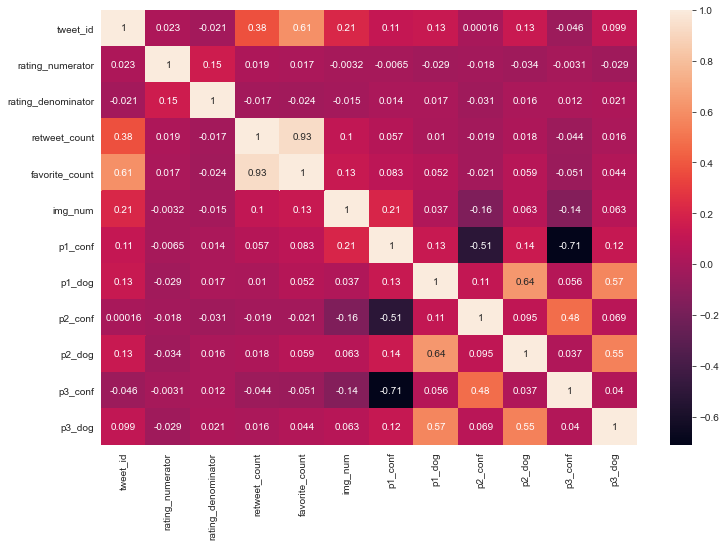

In [89]:
corr_matrix = df_master.corr()
fig, axs = plt.subplots(figsize=(12,8))

sn.heatmap(corr_matrix, annot=True, ax=axs);

As favorites increase, retweets also increase

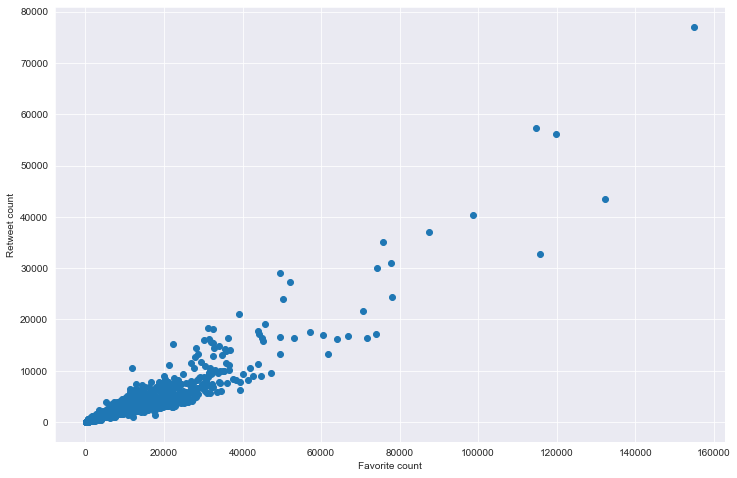

In [90]:
fig = plt.subplots(figsize=(12,8))

plt.scatter(x=df_master['favorite_count'], y=df_master['retweet_count'])
plt.xlabel("Favorite count")
plt.ylabel("Retweet count");

<br/>

Top 10 most common names

In [91]:
dog_names = df_master.query("name !='None'").groupby('name')['name'].count().sort_values(ascending=False).head(10)

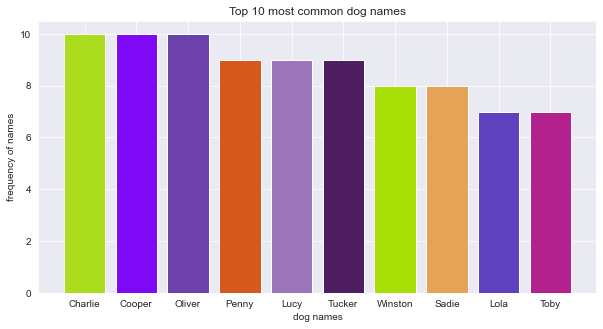

In [92]:
fig = plt.subplots(figsize=(10,5))
locations = np.arange(10)
heights = dog_names
labels = dog_names.index

plt.title("Top 10 most common dog names")
plt.xlabel("dog names")
plt.ylabel("frequency of names")
plt.bar(locations, height=heights, tick_label=labels, color=np.random.rand(len(dog_names),3));

<br/>

Most frquently dog stage in dataframe

In [93]:
columns = ['doggo','floofer','pupper','puppo', 'favorite_count','retweet_count']
dog_stages = df_master[columns].query("doggo != 'None' or floofer != 'None' or pupper != 'None' or puppo != 'None'")

In [94]:
lst_dog_stages = []
lst_dog_stages.append(dog_stages.query("doggo != 'None'").groupby('doggo')['doggo'].count()[0])
lst_dog_stages.append(dog_stages.query("floofer != 'None'").groupby('floofer')['floofer'].count()[0])
lst_dog_stages.append(dog_stages.query("pupper != 'None'").groupby('pupper')['pupper'].count()[0])
lst_dog_stages.append(dog_stages.query("puppo != 'None'").groupby('puppo')['puppo'].count()[0])

Of 1886 entries, only 299 were filled in dog_stage 

In [95]:
sum(lst_dog_stages)

299

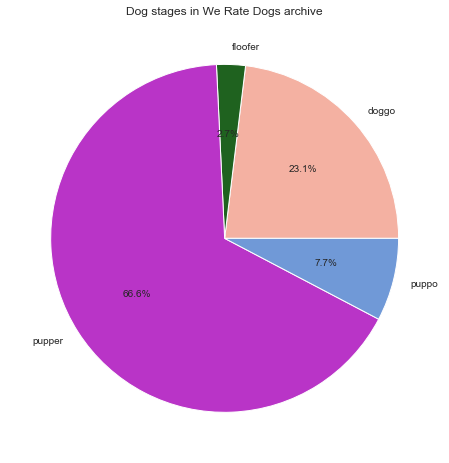

In [96]:
fig = plt.subplots(figsize=(15,8))

heights = lst_dog_stages
labels = ['doggo','floofer','pupper','puppo']
plt.title("Dog stages in We Rate Dogs archive")
plt.pie(heights, labels=labels, autopct="%1.1f%%", colors=np.random.rand(len(heights),3));

In [97]:
# Select only cases that have a bigger chance to predict a reald breed of dog.
# In this case, I chose consider only p1 predictions
select_pupper = df_master.query("pupper == 'pupper' and p1_conf >= 0.90 and p1_dog == True")

In [98]:
# Get the max from favorite_count and retweet_count
max_fav = select_pupper[['favorite_count','retweet_count']].describe()['favorite_count'][7]
max_ret = select_pupper[['favorite_count','retweet_count']].describe()['retweet_count'][7]

In [99]:
# Now, I select the most favorite and most retweet counts
champ_breed = select_pupper.query("favorite_count == @max_fav or retweet_count == @max_ret")

In [100]:
# Now, let't get the breed of pupper champion and make a word cloud with text of all other entries of champion breed
champ_breed['p1'].values[0]

'French_bulldog'

In [101]:
#As much as you have a lovely puppy in the same image, the model recognize only the french bulldog.
# It'ok, let's make a wordcloud of french bulldogs breeds to see what is related to them
champ_breed

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,type,tweet_url
105,866450705531457537,2017-05-22 00:28:40,Twitter for iPhone,This is Jamesy. He gives a kiss to every other...,13,10,Jamesy,None,None,pupper,...,0.905334,True,Boston_bull,0.07806,True,pug,0.001771,True,photo,https://t.co/wk7TfysWHr


In [102]:
print("Total of French bulldog breed in master dataframe: {}".format(df_master.query("p1 == 'French_bulldog'")['tweet_id'].count()))

Total of French bulldog breed in master dataframe: 25


In [103]:
bulldog_image_url = champ_breed['jpg_url'].values[0]

r= requests.get(bulldog_image_url)

with open ('french_bulldog.jpg', 'wb') as image_file:
    image_file.write(r.content)

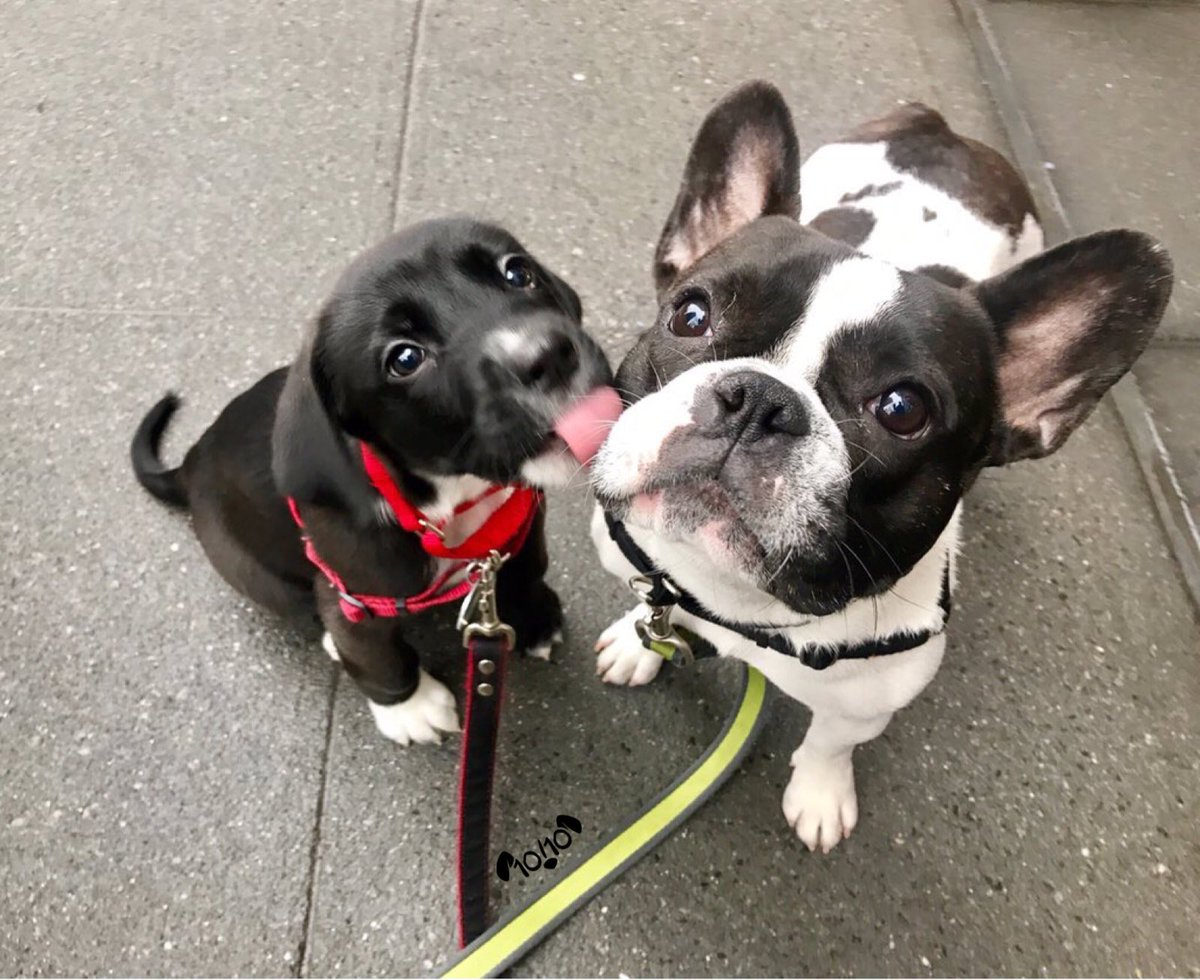

In [104]:
# Get texts from French bulldog breed to generate a wordcloud
texts_list = []
for i in df_master.query("p1 == 'French_bulldog'")['text']:
    texts_list.append(i)

text = str(texts_list)

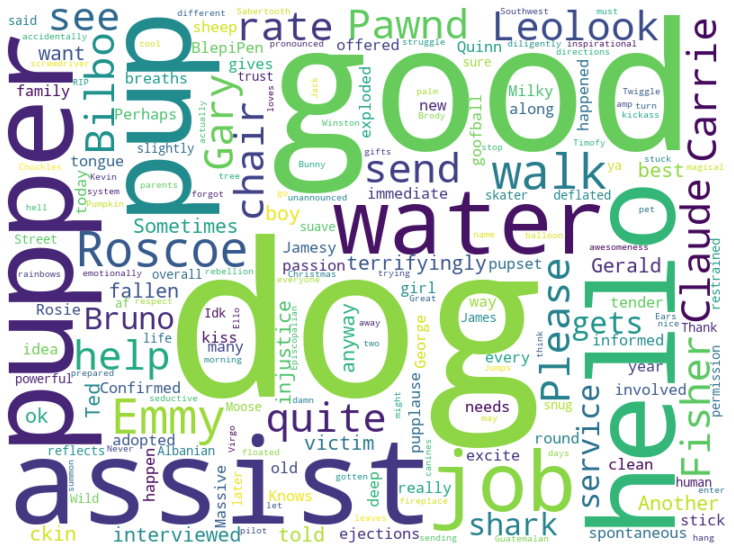

In [105]:
# Generate the word cloud using WordCloud librarie
stopwords = set(STOPWORDS)
stopwords.update(['say','enough','meet','much','even','non'])
wordcloud = WordCloud(background_color='white', stopwords=stopwords, mode='RGB',width=800, height=600).generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
fig = plt.gcf()
fig.savefig('wordcloud_french_bulldog.jpg')

<a id='references'></a>
## References

1. http://www.tweepy.org/
2. https://pypi.org/project/requests/
3. https://pandas.pydata.org/docs/
4. https://docs.python.org/3/
5. https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html
6. https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
7. https://www.datacamp.com/community/tutorials/wordcloud-python
8. https://jtemporal.com/diferenciando-json-loads-de-json-load-e-uma-pitade-de-bigquery/
9. https://stackoverflow.com/questions/11331982/how-to-remove-any-url-within-a-string-in-python
10. https://regex101.com/#python
11. https://knowyourmeme.com/memes/theyre-good-dogs-brent
12. https://www.scivision.co/python-windows-visual-c-14-required